In [45]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import metrics, cross_validation
import sys
from scipy import spatial
from matplotlib import pylab as plt, image as img
from operator import itemgetter
%matplotlib inline

In [46]:
# File paths
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

In [47]:
# Read in the datasets from the respective CSV files
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

In [48]:
# Store as numpy arrays
train_digits = train_data.ix[:,1:].values
train_labels = train_data['label'].values
test_digits = test_data.values

In [49]:
def get_digit_info (labels):
    digit_flag, digit_freq, first_instance_idx = np.zeros(10), np.zeros(10), {}
    for i, label in enumerate(labels):
        digit_freq[labels[i]] += 1
        if digit_flag[label] == False:
            digit_flag[label] = True
            first_instance_idx[label] = i
    return (first_instance_idx, dict(zip(range(10), digit_freq / sum(digit_freq))))

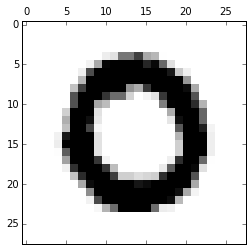

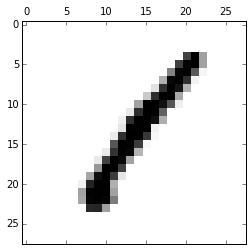

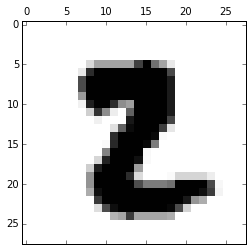

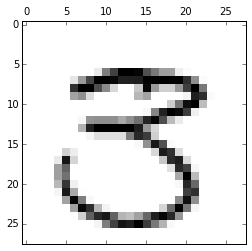

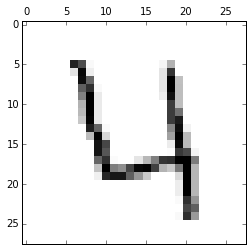

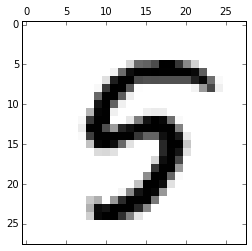

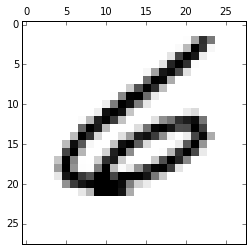

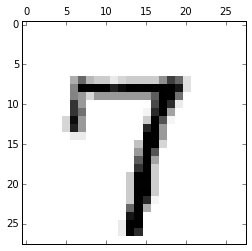

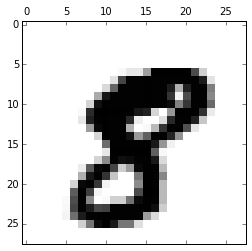

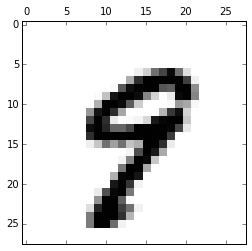

In [50]:
# Display MNIST digits
def display_digit (digit, label):
    d = digit.reshape(28,28)
    plt.matshow(d, cmap='gray_r')
    img.imsave('digit_' + str(label), d, cmap="gray_r")
    return

# Get frequencies of each digit and first instance index
indices, frequencies = get_digit_info(train_labels)

# Print one of each
for i in range(len(indices)):
    display_digit(train_digits[indices[i]], i)

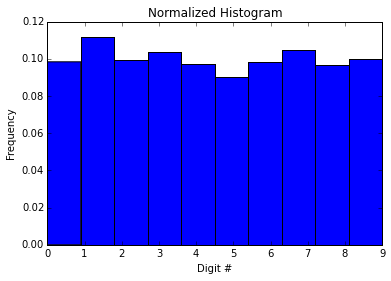

In [51]:
# Build normalized histogram
def build_normalized_histogram(digit_freq, labels):
    fig = plt.figure()
    plt.hist(digit_freq.keys(), weights=digit_freq.values())
    plt.title('Normalized Histogram')
    plt.xlabel('Digit #')
    plt.ylabel('Frequency')
    plt.gca().set_xlim([0, 9])
    fig.savefig('norm_hist.png')
    return
    
build_normalized_histogram(frequencies, train_labels)

In [52]:
# Find the best matches
def find_best_matches(first_instance, digits, labels):
    best_fits = [(sys.maxint, -1)] * 10 # best fit array containing a tuple (distance, idx) for each digit
    for idx, digit in enumerate(digits): # for each matrix of pixels
        if idx != first_instance[labels[idx]]: # if not first instance of this digit
            L2 = spatial.distance.euclidean(digits[first_instance[labels[idx]]], digit) # Distance = euclidean(first_instance_matrix, pixel_matrix[idx])
            if L2 < best_fits[labels[idx]][0]: # if current distance < current smallest distance
                best_fits[labels[idx]] = (L2, idx) # set new distance as smallest 
    return best_fits

best_fits = find_best_matches(indices, train_digits, train_labels)

for digit, fit in enumerate(best_fits):
        print "L2 distance between sample {0} and nearest neighbor: {1} pixels".format(digit, fit[0])

L2 distance between sample 0 and nearest neighbor: 1046.59543282 pixels
L2 distance between sample 1 and nearest neighbor: 489.679487012 pixels
L2 distance between sample 2 and nearest neighbor: 1380.8772574 pixels
L2 distance between sample 3 and nearest neighbor: 1834.63620372 pixels
L2 distance between sample 4 and nearest neighbor: 1356.88098225 pixels
L2 distance between sample 5 and nearest neighbor: 1066.36766643 pixels
L2 distance between sample 6 and nearest neighbor: 1446.51132038 pixels
L2 distance between sample 7 and nearest neighbor: 863.501013317 pixels
L2 distance between sample 8 and nearest neighbor: 1593.777588 pixels
L2 distance between sample 9 and nearest neighbor: 910.576740314 pixels


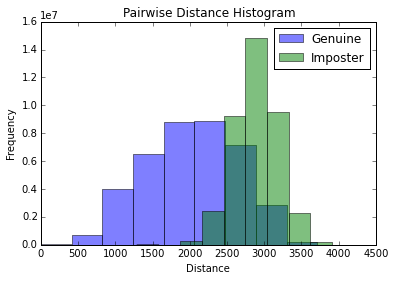

In [63]:
# Get pairwise distance and plot histograms
def get_pairswise_distance (digits, labels):
    binary_classifier = {"zeros": [], "ones": []}

    for idx, digit in enumerate(digits):
        # Only concerned with digits 0 and 1
        if labels[idx] > 1:
            continue
        elif labels[idx] == 0:
            binary_classifier['zeros'].append(digit)
        else:
            binary_classifier['ones'].append(digit)

    # Genuine values
    genuine_zero = metrics.pairwise.pairwise_distances(binary_classifier['zeros']).flatten()
    genuine_one = metrics.pairwise.pairwise_distances(binary_classifier['ones']).flatten()
    genuine_total = np.concatenate((genuine_zero, genuine_one))

    # Imposter values
    imposter_zero = metrics.pairwise.pairwise_distances(binary_classifier['zeros'], binary_classifier['ones']).flatten()
    imposter_one = metrics.pairwise.pairwise_distances(binary_classifier['ones'], binary_classifier['zeros']).flatten()
    imposter_total = np.concatenate((imposter_zero, imposter_one))

    return (genuine_total, imposter_total)

def plot_pairwise_distance (genuine, imposter):
    fig = plt.figure()
    plt.hist(genuine, alpha=0.5, label='Genuine')
    plt.hist(imposter, alpha=0.5, label='Imposter')
    plt.title('Pairwise Distance Histogram')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    fig.savefig('pw_distance.png')
    return

genuine, imposter = get_pairswise_distance(train_digits, train_labels)
plot_pairwise_distance(genuine, imposter)

In [121]:
# Plot ROC Curve
def plot_roc_curve (genuine, imposter):
    zeros = np.zeros(len(genuine))
    ones = np.ones(len(imposter))
    y_true = np.concatenate((zeros, ones))
    y_score = np.concatenate((genuine, imposter))
    
    # Remember - lower distance is a higher score! 
    # To account for that, subtract all distances from max distance and plot
    m = max(y_score)
    for i in range(len(y_score)):
        y_score[i] = np.float(m - y_score[i])
        
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=0)
    roc_auc = sk.metrics.auc(fpr, tpr)
    
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.plot([1,0], 'g--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    fig.savefig('roc_curve.png')
    return (fpr, tpr)

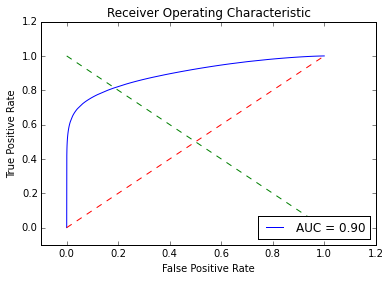

In [122]:
fpr, tpr = plot_roc_curve(genuine, imposter)

In [56]:
# Implement KNN Classifier
class KNNeighborsClassifier:
    def __init__(self, k_neighbors, train_data, labels, test_data):
        self.k_neighbors = k_neighbors
        self.train_data = train_data
        self.labels = labels
        self.test_data = test_data
        return

    def get_neighbors(self, X):
        neighbors = []
        for idx1, point1 in enumerate(X): # for each matrix of pixels
            distances = []
            [distances.append((spatial.distance.euclidean(point1, point2), idx2)) for idx2, point2 in enumerate(X)]
            distances.sort(key=itemgetter(0)) # sort list of tuples based on key 0, or distance!
            nearest_neighbors = distances[1:self.k_neighbors+1] # remove 0 distance while comparing the same value
            neighbors.append(nearest_neighbors)
        return neighbors
    
    def get_neighbors(self, k, train, test_inst):
        neighbors = []
        for idx, point in enumerate(train):
            neighbors.append((spatial.distance.euclidean(point, test_inst), idx))
        neighbors.sort(key=itemgetter(0))
        return neighbors[:k]
    
    def classifier(self, nearest_neighbors, digit_labels):
        possible_classes = []
        for neighbor in nearest_neighbors:
            possible_classes.append(digit_labels[neighbor[1]])

        return max(set(possible_classes), key=possible_classes.count)

    def predict(self, test_data):
        predicted_digits = []
        for test_instance in test_data:
            neighbors = self.get_neighbors(self.k_neighbors, self.train_data, test_instance)
            predicted_digits.append(self.classifier(neighbors, self.labels))
        return predicted_digits     

In [57]:
# Cross validation
def cross_validate (folds, digits, labels):
    cv = cross_validation.KFold(len(digits),  n_folds=folds)
    results = []
    for train_idx, test_idx in cv:
        # Divide into buckets
        x_train = digits[train_idx]
        y_train = labels[train_idx]
        x_test = digits[test_idx]
        y_test = labels[test_idx]
        
        # Fit and predict
        kNN = KNNeighborsClassifier(3, x_train, y_train, x_test)
        prediction = kNN.predict(x_test)
        accuracy = (prediction == y_test).sum() / float(len(y_test))
        confusion_matrix = metrics.confusion_matrix(y_test, prediction)
        results.append((prediction, accuracy, confusion_matrix))  
    return results

In [22]:
results = cross_validate(3, train_digits, train_labels)

# Print results of cross validation
predictions, accuracy, confusion_matrix = [], [], []
s = 0
for p, a, c in results:
    s += len(p)
    predictions.append(p)
    accuracy.append(a)
    confusion_matrix.append(c)
    
print "Number of digits: ", s
print "Number of folds: ", "3"
print "Mean accuracy: ", np.mean(accuracy)
print "Confusion Matrix: \n", sum(confusion_matrix)

cf_matrix = pd.DataFrame(sum(confusion_matrix))
file_name = "confusion_matrix_" + str(s) + '.csv' 
cf_matrix.to_csv(file_name)

Number of digits:  42000
Number of folds:  3
Mean accuracy:  0.966166666667
Confusion Matrix: 
[[4110    0    4    0    0    5   10    0    2    1]
 [   0 4655    8    1    2    1    4    7    3    3]
 [  31   46 3982   12    3    3    4   73   15    8]
 [   6   12   30 4182    0   37    2   21   37   24]
 [   3   43    0    0 3887    0   15    4    3  117]
 [  14    2    1   65    2 3614   43    2   14   38]
 [  26    6    0    0    5   17 4080    0    3    0]
 [   2   54    9    1    8    0    0 4268    0   59]
 [  20   45   10   42   14   68   17   10 3792   45]
 [  14    9    2   26   38   10    2   58   20 4009]]


In [59]:
# Fit and predict using our KNN Classifier
kNN = KNNeighborsClassifier(3, train_digits, train_labels, test_digits)
predicted_values = kNN.predict(test_digits)
id = range(1, len(predicted_values)+1)      

submission = pd.DataFrame({'ImageId': id, 'Label': predicted_values})
file_name = "digit_recogition_submission_" + str(len(predicted_values)) + '.csv' 
submission.to_csv(file_name, index=False)
print submission

       ImageId  Labels
0            1       2
1            2       0
2            3       9
3            4       9
4            5       3
5            6       7
6            7       0
7            8       3
8            9       0
9           10       3
10          11       5
11          12       7
12          13       4
13          14       0
14          15       4
15          16       3
16          17       3
17          18       1
18          19       9
19          20       0
20          21       9
21          22       1
22          23       1
23          24       5
24          25       7
25          26       4
26          27       2
27          28       7
28          29       4
29          30       7
...        ...     ...
27970    27971       5
27971    27972       0
27972    27973       4
27973    27974       8
27974    27975       0
27975    27976       3
27976    27977       6
27977    27978       0
27978    27979       1
27979    27980       9
27980    27981       3
27981    27